In [1]:
# Install transformers library.
#!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
#!pip install -q git+https://github.com/gmihaila/ml_things.git

In [3]:
# import libraries

import io
import os
import torch
import numpy as np
import random
import os
import csv
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd


In [4]:
# Initialize seeder and randomness
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
#tf.random.set_seed(seed)

In [5]:
# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
#model_name_or_path = 'microsoft/CodeGPT-small-py' # 'microsoft/CodeGPT-small-py' # 'gpt2'
model_name_or_path = 'gpt2' # './model_logs' './model_logs_fromScratch'

In [6]:
# Pre-processing
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

# Read pre-processed dataset
with open('data_reduced_bert.csv', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)
random.shuffle(data)
#data = data[0:100] # subsample for checking

In [6]:
def getLengths(data):
    lens = []
    for i in range(len(data)):
        lens.append(len(data[i])-2)
    lens = pd.DataFrame(lens)
    lensFreq = lens[0].value_counts()
    lensFreq=pd.DataFrame(lensFreq)
    return lens, lensFreq

lens, lensFreq = getLengths(data)
max_len = max(lens[0])
max_len

510

In [7]:
labs = []
for d in data:
    labs.append(d[1])

In [8]:
# Creation of the dataset's repository
val_ratio = 0.15

## split dataset to train-val-test sets
### split data into train and test (85% train, 15% test)
train_val, test = train_test_split(data, test_size=val_ratio, random_state=seed, stratify = labs)

labs2 = []
for d in train_val:
    labs2.append(d[1])

### split train and validation
train, val = train_test_split(train_val, test_size=val_ratio, random_state=seed, stratify = labs2)


## create the base directory if it doesn't exist
if not os.path.exists('pythonvp'):
    os.mkdir('pythonvp')

## create subdirectories for clean and vuln
for subset in ['train', 'val', 'test']:
    if not os.path.exists(os.path.join('pythonvp', subset)):
        os.mkdir(os.path.join('pythonvp', subset))

    ### create subdirectories for train, val, and test
    for category in ['clean', 'vuln']:
        if not os.path.exists(os.path.join('pythonvp', subset, category)):
            os.mkdir(os.path.join('pythonvp', subset, category))

## write files to appropriate directories
def makeRepo(data, subset):
    for item in data:
        filename = item[0]
        category = 'clean' if item[1] == '0' else 'vuln'
        body = ' '.join([str(token) for token in item[2:]])

        with open(os.path.join('pythonvp', subset, category, filename[:-3] + '.py'), 'w') as f:
            f.write(body)

            
## call makeRepo function
makeRepo(train, 'train')
makeRepo(val, 'val')
makeRepo(test, 'test')

## Merge train and val folders
subset = "train_val"
if not os.path.exists(os.path.join('pythonvp', subset)):
        os.mkdir(os.path.join('pythonvp', subset))
for category in ['clean', 'vuln']:
        if not os.path.exists(os.path.join('pythonvp', subset, category)):
            os.mkdir(os.path.join('pythonvp', subset, category))

makeRepo(train_val, 'train_val')

In [9]:
# define models and parameters
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(seed)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 6

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 6

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 512

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'clean': 0, 'vuln': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


In [10]:
class VulnCodeDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in ['vuln', 'clean']:
      code_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(code_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(code_path, file_name)

        # Read content.
        
        #content = io.open(file_path, mode='r', encoding='utf-8').read()
        content = io.open(file_path, mode='r', encoding="ISO-8859-1").read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


In [11]:
def getUniques(data):
    allWords = []
    for i in range(len(data)):
        for j in range(2, len(data[i])):
            allWords.append(data[i][j])
    
    vc = pd.Series(allWords).value_counts()
    uniques=vc.index.values.tolist()        
    return allWords, uniques, vc

def getVocab(data):
    ## split dataset to train-val-test sets
    ### split data into train and test (85% train, 15% test)
    train_val_indices, test_indices = train_test_split(range(len(data)), test_size=val_ratio, random_state=seed)
    train_val_data = [data[i] for i in train_val_indices]

    allWords, vocab, freqs = getUniques(train_val_data)
    return vocab

def addTokens(data, tokenizer, model):
    new_tokens = getVocab(data)

    for new_token in new_tokens:
        if new_token not in tokenizer.get_vocab().keys():
            tokenizer.add_tokens(new_token)

    # resize model embedding to match new tokenizer
    model.resize_token_embeddings(len(tokenizer))
    return tokenizer, model

In [12]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path, do_lower_case = True)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# add all new tokens
#tokenizer, model = addTokens(data, tokenizer, model)

# fix model new tokens ids

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of the model checkpoint at ./model_logs_fromScratch were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ./model_logs_fromScratch and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [13]:
encoded_input = tokenizer("Here is an example sentence with strId$ and numId$ tokens.", padding=True, truncation=True, max_length=512, return_tensors="pt")
encoded_input

{'input_ids': tensor([[31829,   341,   555,  2474,  6570,   538, 50004,   342, 50005,  2969,
            16]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = VulnCodeDataset(path='pythonvp\\train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  VulnCodeDataset(path='pythonvp\\val', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

print('Dealing with Testing...')
# Create pytorch dataset.
test_dataset =  VulnCodeDataset(path='pythonvp\\test', 
                               use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))



# Create pytorch dataset.
train_val_dataset = VulnCodeDataset(path='pythonvp\\train_val', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_val_dataset))

# Move pytorch dataset into dataloader.
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_val_dataloader))


Dealing with Train...


vuln files:   0%|          | 0/924 [00:00<?, ?it/s]

clean files:   0%|          | 0/2932 [00:00<?, ?it/s]

Created `train_dataset` with 3856 examples!
Created `train_dataloader` with 643 batches!

Dealing with Validation...


vuln files:   0%|          | 0/238 [00:00<?, ?it/s]

clean files:   0%|          | 0/767 [00:00<?, ?it/s]

Created `valid_dataset` with 1005 examples!
Created `eval_dataloader` with 168 batches!
Dealing with Testing...


vuln files:   0%|          | 0/275 [00:00<?, ?it/s]

clean files:   0%|          | 0/890 [00:00<?, ?it/s]

Created `test_dataset` with 1165 examples!
Created `eval_dataloader` with 195 batches!


vuln files:   0%|          | 0/973 [00:00<?, ?it/s]

clean files:   0%|          | 0/3120 [00:00<?, ?it/s]

Created `train_dataset` with 4093 examples!
Created `train_dataloader` with 683 batches!


C:\Users\Ilias\anaconda3\envs\torchenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch  1
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.52777 - val_loss: 0.23351 - train_acc: 0.79046 - valid_acc: 0.89950

Validation F2-score:  0.7540702656383891
Epoch  2
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.34498 - val_loss: 0.23497 - train_acc: 0.89263 - valid_acc: 0.93433

Validation F2-score:  0.8530405405405406
Epoch  3
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.25192 - val_loss: 0.21710 - train_acc: 0.93672 - valid_acc: 0.93831

Validation F2-score:  0.9176182707993474
Epoch  4
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.20514 - val_loss: 0.15294 - train_acc: 0.95306 - valid_acc: 0.96517

Validation F2-score:  0.9036658141517476
Epoch  5
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.14327 - val_loss: 0.14162 - train_acc: 0.96888 - valid_acc: 0.97512

Validation F2-score:  0.9382924767540153
Epoch  6
Training on batches...


  0%|          | 0/643 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/168 [00:00<?, ?it/s]

  train_loss: 0.12571 - val_loss: 0.12585 - train_acc: 0.97329 - valid_acc: 0.97811

Validation F2-score:  0.9589614740368511


C:\Users\Ilias\anaconda3\envs\torchenv\lib\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


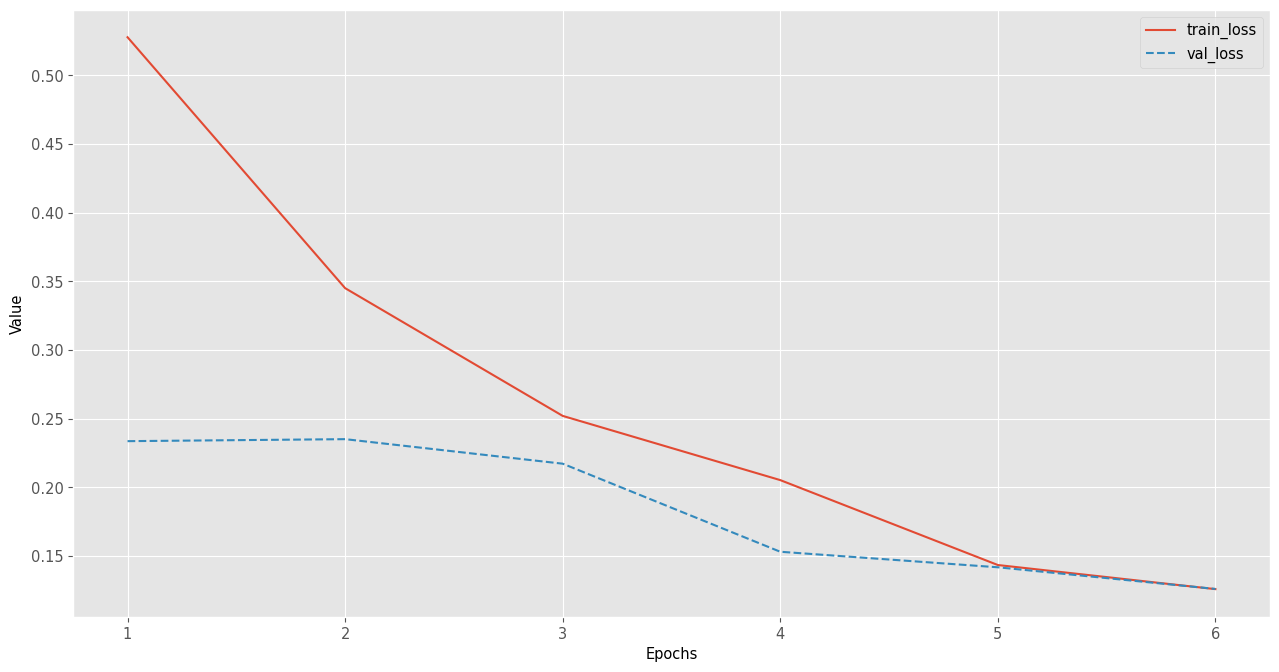

C:\Users\Ilias\anaconda3\envs\torchenv\lib\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


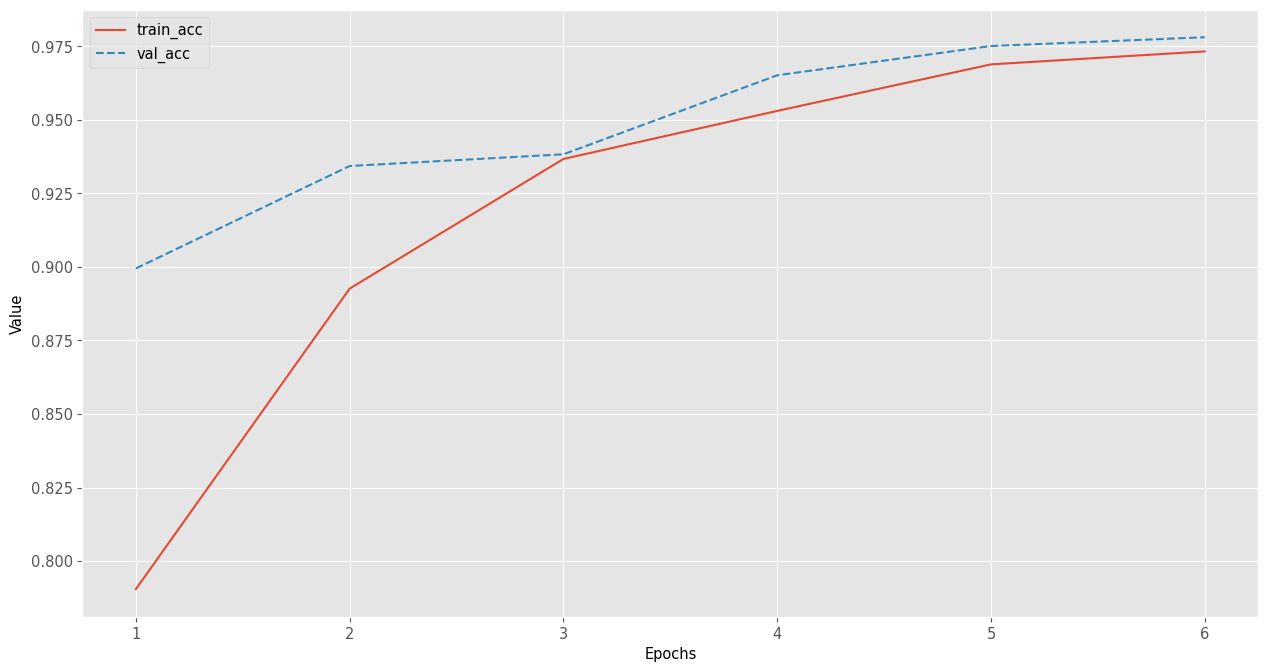

C:\Users\Ilias\anaconda3\envs\torchenv\lib\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


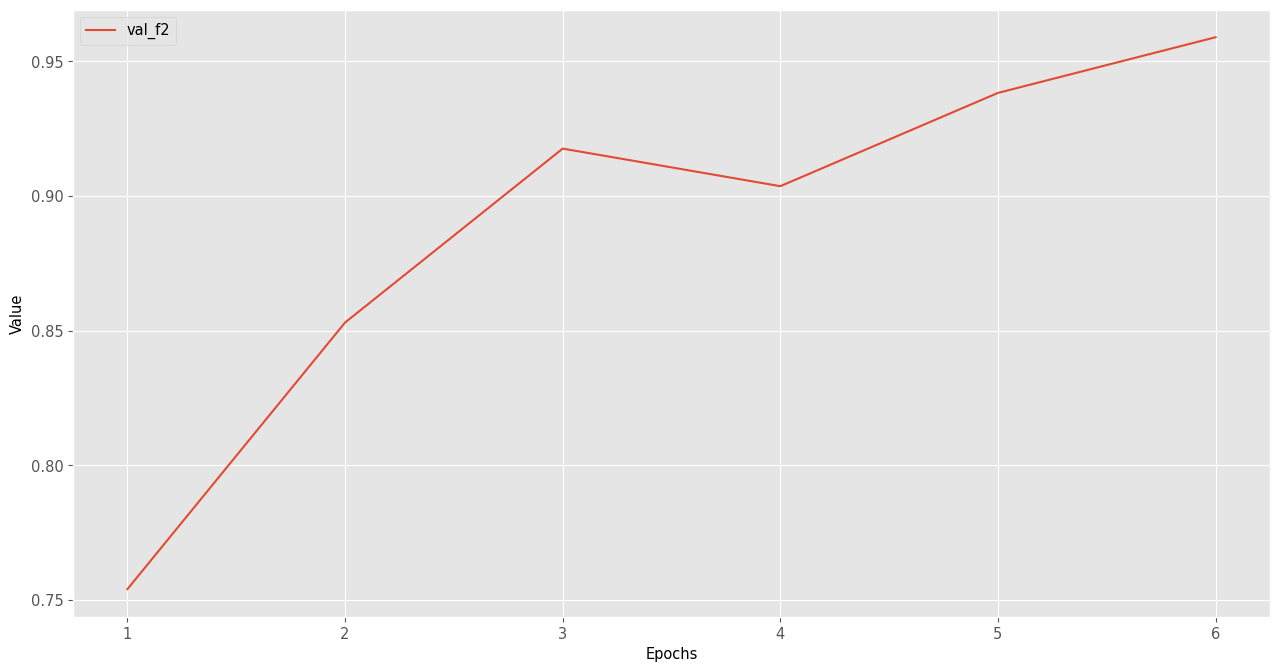

In [15]:

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
valid_f2 = {'val_f2':[]}

# Loop through each epoch.
ep=0
for epoch in tqdm(range(epochs)):
  ep=ep+1
  print("Epoch ", ep)
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()
  
  tn, fp, fn, tp = confusion_matrix(valid_labels, valid_predict).ravel()
  val_acc=(tp+tn)/(tp+tn+fp+fn)
  val_prec=tp/(tp+fp)
  val_rec=tp/(tp+fn)
  val_f1=2*val_prec*val_rec / (val_prec+val_rec)
  val_f2=5*val_prec*val_rec / (4*val_prec+val_rec)
  #print("Accuracy: ", val_acc)
  #print("Precision: ", val_prec)
  #print("Recall: ", val_rec)
  #print("F1-score: ", val_f1)
  print("Validation F2-score: ", val_f2)

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)
  valid_f2['val_f2'].append(val_f2)
    
# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot f2 curve.
plot_dict(valid_f2, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


              precision    recall  f1-score   support

       clean       0.99      0.98      0.99       767
        vuln       0.95      0.96      0.95       238

    accuracy                           0.98      1005
   macro avg       0.97      0.97      0.97      1005
weighted avg       0.98      0.98      0.98      1005

Confusion matrix, without normalization


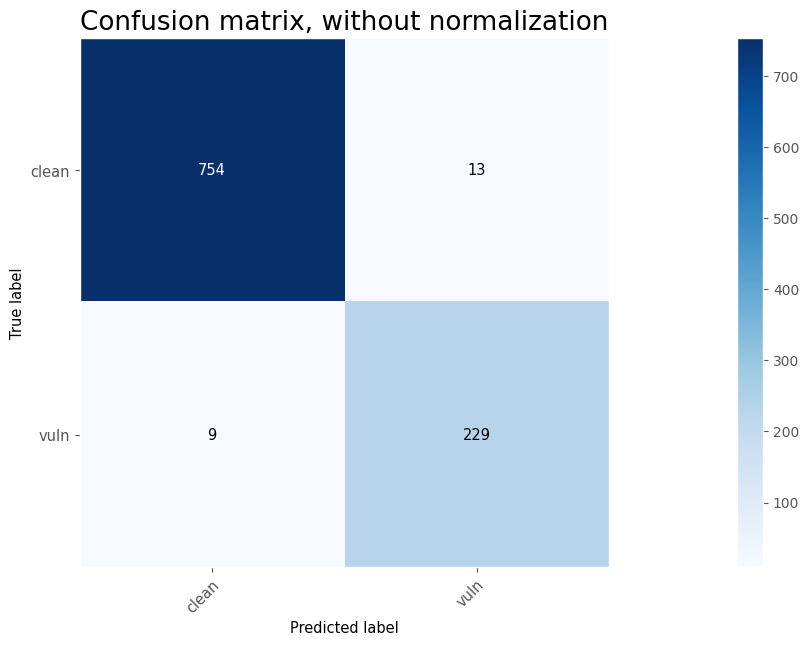

754 13 9 229
Accuracy:  0.9781094527363184
Precision:  0.9462809917355371
Recall:  0.9621848739495799
F1-score:  0.9541666666666666
F2-score:  0.9589614740368511


In [16]:
# Get prediction form model on validation data. This is where you should use your val data.

# Create the evaluation report.
evaluation_report = classification_report(valid_labels, valid_predict, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=valid_labels, y_pred=valid_predict, 
                      classes=list(labels_ids.keys()),
                      );

cm = confusion_matrix(valid_labels, valid_predict, labels=[0, 1])
tn, fp, fn, tp = confusion_matrix(valid_labels, valid_predict).ravel()
print(tn, fp, fn, tp)

val_acc=(tp+tn)/(tp+tn+fp+fn)
val_prec=tp/(tp+fp)
val_rec=tp/(tp+fn)
val_f1=2*val_prec*val_rec / (val_prec+val_rec)
val_f2=5*val_prec*val_rec / (4*val_prec+val_rec)
print("Accuracy: ", val_acc)
print("Precision: ", val_prec)
print("Recall: ", val_rec)
print("F1-score: ", val_f1)
print("F2-score: ", val_f2)

In [18]:
new_epochs = 6 # selected number by validation

# train on train_val set for optimal n_epochs

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 #
                  )

total_steps = len(train_val_dataloader) * new_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(new_epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_val_labels, train_val_predict, train_val_loss = train(train_val_dataloader, optimizer, scheduler, device)
  train_val_acc = accuracy_score(train_val_labels, train_val_predict)


  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - train_acc: %.5f:"%(train_val_loss, train_val_acc))

Epoch


  0%|          | 0/6 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.24418 - train_acc: 0.94943:

Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.18592 - train_acc: 0.96335:

Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.14994 - train_acc: 0.97190:

Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.12804 - train_acc: 0.97703:

Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.09533 - train_acc: 0.98339:

Training on batches...


  0%|          | 0/683 [00:00<?, ?it/s]

  train_loss: 0.09151 - train_acc: 0.98363:


  0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       clean       0.99      0.98      0.99       890
        vuln       0.95      0.97      0.96       275

    accuracy                           0.98      1165
   macro avg       0.97      0.98      0.97      1165
weighted avg       0.98      0.98      0.98      1165

Confusion matrix, without normalization


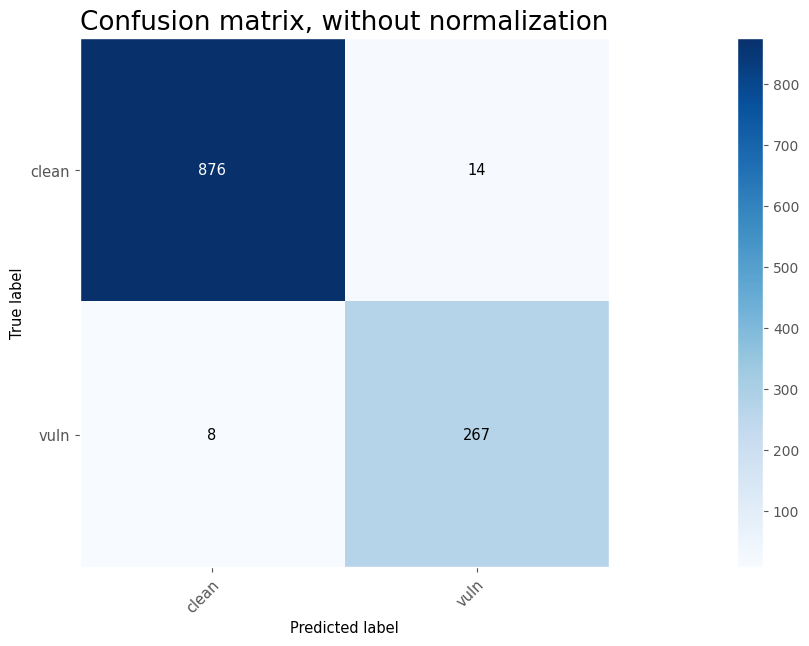

In [19]:
# Get prediction form model on testing data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()),
                      );


In [20]:
cm = confusion_matrix(true_labels, predictions_labels, labels=[0, 1])
tn, fp, fn, tp = confusion_matrix(true_labels, predictions_labels).ravel()
(tn, fp, fn, tp)

(876, 14, 8, 267)

In [21]:
acc=(tp+tn)/(tp+tn+fp+fn)
prec=tp/(tp+fp)
rec=tp/(tp+fn)
f1=2*prec*rec / (prec+rec)
f2=5*prec*rec / (4*prec+rec)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)
print("F2-score: ", f2)

Accuracy:  0.9811158798283262
Precision:  0.9501779359430605
Recall:  0.9709090909090909
F1-score:  0.960431654676259
F2-score:  0.9666908037653874
